# POPPY Examples 

**This is a notebook version of the examples available in the POPPY documentation at http://pythonhosted.org/poppy/examples.html**

**It differs only cosmetically from the code there: it contains some extra function calls to set an aesthetically pleasing size for each plot, and to save the outputs to PNGs for inclusion in the documentation source code. These lines are left out of the example docs HTML page just to streamline it a bit.**

In [1]:
%pylab inline
import poppy

Populating the interactive namespace from numpy and matplotlib


Let’s dive right in to some example code.

For all of the following examples, you will have more informative text output when running the code if you first enable Python’s logging mechanism to display log messages to screen:

In [2]:
import logging
logging.basicConfig(level=logging.DEBUG)

## A simple circular pupil¶

This is very simple, as it should be:

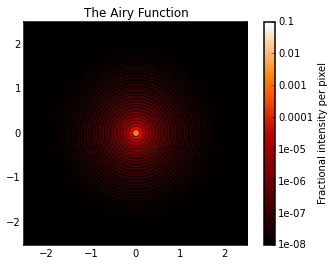

In [47]:
osys = poppy.OpticalSystem()
osys.addPupil( poppy.CircularAperture(radius=3))    # pupil radius in meters
osys.addDetector(pixelscale=0.010, fov_arcsec=5.0)  # image plane coordinates in arcseconds

psf = osys.calcPSF(2e-6)                            # wavelength in microns
poppy.display_PSF(psf, title='The Airy Function') 

plt.savefig('example_airy.png', dpi=100)

## A complex segmented pupil¶


By combining multiple analytic optics together it is possible to create quite complex pupils:

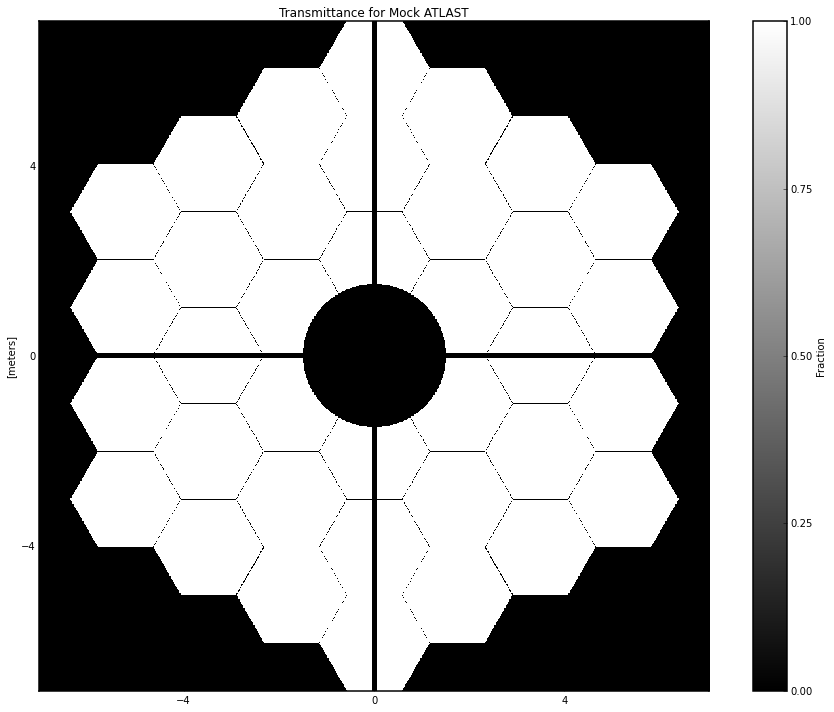

In [48]:
plt.figure(figsize=(16,12))

ap = poppy.MultiHexagonAperture(rings=3, flattoflat=2)           # 3 rings of 2 m segments yields 14.1 m circumscribed diameter
sec = poppy.SecondaryObscuration(secondary_radius=1.5, n_supports=4, support_width=0.1)   # secondary with spiders
atlast = poppy.CompoundAnalyticOptic( opticslist=[ap, sec], name='Mock ATLAST')           # combine into one optic

atlast.display(npix=1024, colorbar_orientation='vertical')
plt.savefig('example_atlast_pupil.png', dpi=100)

And here’s the PSF:

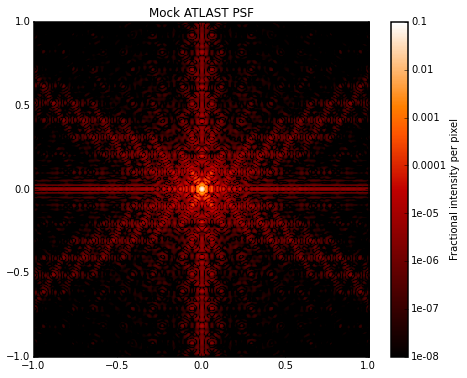

In [49]:
plt.figure(figsize=(8,6))

osys = poppy.OpticalSystem()
osys.addPupil(atlast)
osys.addDetector(pixelscale=0.010, fov_arcsec=2.0)
psf = osys.calcPSF(1e-6)

poppy.display_PSF(psf, title="Mock ATLAST PSF")
plt.savefig('example_atlast_psf.png', dpi=100)

## Multiple defocused PSFs¶

Defocus can be added using a lens:

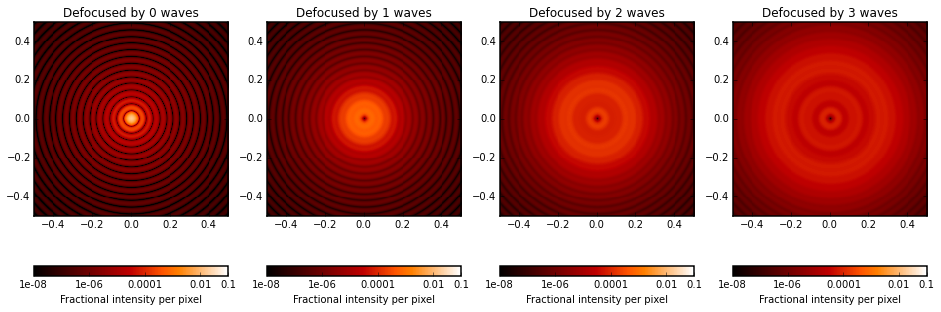

In [50]:
plt.figure(figsize=(16,6))

wavelen=1e-6
nsteps = 4
psfs = []
for nwaves in range(nsteps):

    osys = poppy.OpticalSystem("test", oversample=2)
    osys.addPupil( poppy.CircularAperture(radius=3))    # pupil radius in meters
    osys.addPupil( poppy.ThinLens(nwaves=nwaves, reference_wavelength=wavelen, radius=3))
    osys.addDetector(pixelscale=0.01, fov_arcsec=4.0)

    psf = osys.calcPSF(wavelength=wavelen)
    psfs.append(psf)

    plt.subplot(1,nsteps, nwaves+1)
    poppy.display_PSF(psf, title='Defocused by {0} waves'.format(nwaves),
        colorbar_orientation='horizontal', imagecrop=1.0)
plt.savefig('example_defocus.png', dpi=100)

## Band Limited Coronagraph with Off-Axis Source
As an example of a more complicated calculation, here’s a NIRCam-style band limited coronagraph with the source not precisely centered:

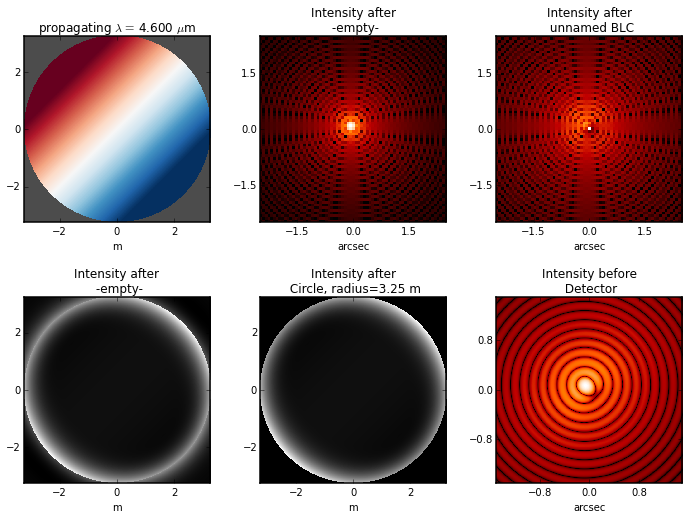

In [51]:
plt.figure(figsize=(12,8))
plt.subplots_adjust(hspace=0.4)

oversample=2
pixelscale = 0.010  #arcsec/pixel
wavelength = 4.6e-6

osys = poppy.OpticalSystem("test", oversample=oversample)
osys.addPupil(poppy.CircularAperture(radius=6.5/2))
osys.addImage()
osys.addImage(poppy.BandLimitedCoron(kind='circular',  sigma=5.0))
osys.addPupil()
osys.addPupil(poppy.CircularAperture(radius=6.5/2))
osys.addDetector(pixelscale=pixelscale, fov_arcsec=3.0)

osys.source_offset_theta = 45.
osys.source_offset_r =  0.1  # arcsec
psf = osys.calcPSF(wavelength=wavelength, display_intermediates=True)
plt.savefig('example_BLC_offset.png', dpi=100)

## FQPM coronagraph
Four quadrant phase mask coronagraphs are a bit more complicated because one needs to ensure proper alignment of the FFT result with the center of the phase mask. This is done using a virtual optic called an ‘FQPM FFT aligner’ as follows:

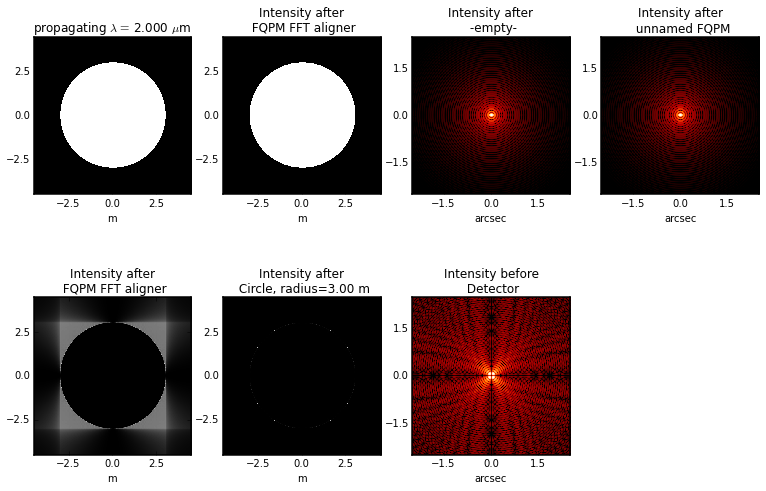

In [52]:
plt.figure(figsize=(13,8))
plt.subplots_adjust(hspace=0.4, wspace=0.2)

optsys = poppy.OpticalSystem()
optsys.addPupil( poppy.CircularAperture( radius=3, pad_factor=1.5)) #pad display area by 50%
optsys.addPupil( poppy.FQPM_FFT_aligner())   # ensure the PSF is centered on the FQPM cross hairs
optsys.addImage()  # empty image plane for "before the mask"
optsys.addImage( poppy.IdealFQPM(wavelength=2e-6))
optsys.addPupil( poppy.FQPM_FFT_aligner(direction='backward'))  # undo the alignment tilt after going back to the pupil plane
optsys.addPupil( poppy.CircularAperture( radius=3)) # Lyot mask - change radius if desired
optsys.addDetector(pixelscale=0.01, fov_arcsec=10.0)


psf = optsys.calcPSF(wavelength=2e-6, display_intermediates=True)

plt.savefig('example_FQPM.png', dpi=100)

## FQPM on an Obscured Aperture (demonstrates compound optics)
As a variation, we can add a secondary obscuration. This can be done by creating a compound optic consisting of the circular outer aperture plus an opaque circular obscuration. The latter we can make using the InverseTransmission class.

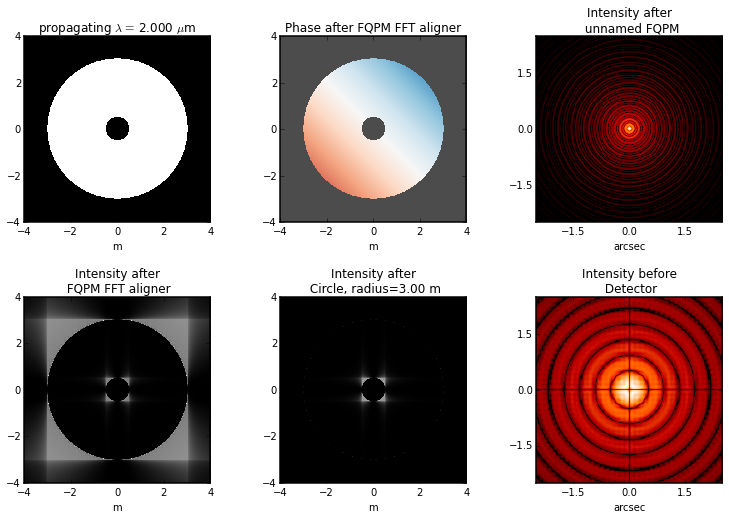

In [53]:
plt.figure(figsize=(13,8))
plt.subplots_adjust(hspace=0.4, wspace=0.2)

primary = poppy.CircularAperture( radius=3, pad_factor=1.5)
secondary = poppy.InverseTransmission( poppy.CircularAperture(radius=0.5) )
aperture = poppy.CompoundAnalyticOptic( opticslist = [primary, secondary] )

optsys = poppy.OpticalSystem()
optsys.addPupil( aperture)
optsys.addPupil( poppy.FQPM_FFT_aligner())   # ensure the PSF is centered on the FQPM cross hairs
optsys.addImage( poppy.IdealFQPM(wavelength=2e-6))
optsys.addPupil( poppy.FQPM_FFT_aligner(direction='backward'))  # undo the alignment tilt after going back to the pupil plane
optsys.addPupil( poppy.CircularAperture( radius=3)) # Lyot mask - change radius if desired
optsys.addDetector(pixelscale=0.01, fov_arcsec=10.0)

optsys.display()

psf = optsys.calcPSF(wavelength=2e-6, display_intermediates=True)
plt.savefig('example_FQPM_obscured.png', dpi=100)

## Semi-analytic Coronagraph Calculations
In some cases, coronagraphy calculations can be sped up significantly using the semi-analytic algorithm of Soummer et al. This is implemented by first creating an OpticalSystem as usual, and then casting it to a SemiAnalyticCoronagraph class (which has a special customized propagation method implementing the alternate algorithm):

The following code performs the same calculation both ways and compares their speeds:

Elapsed time, FFT:  34.041 s
Elapsed time, SAM:  1.519 s


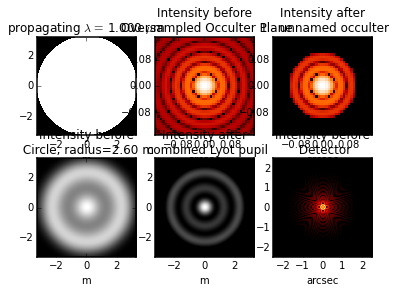

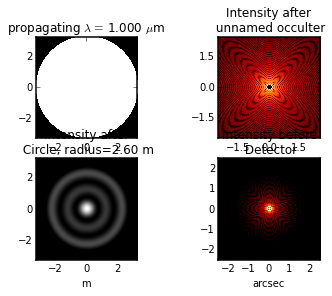

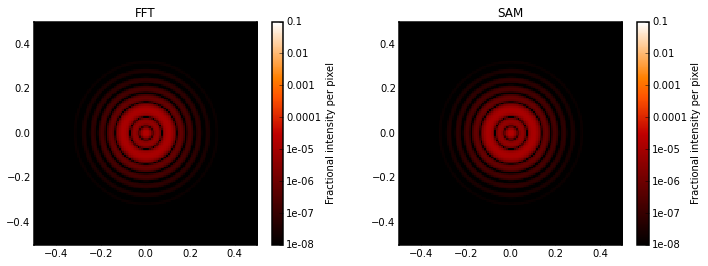

In [54]:
radius = 6.5/2
lyot_radius = 6.5/2.5
pixelscale = 0.060

osys = poppy.OpticalSystem("test", oversample=8)
osys.addPupil( poppy.CircularAperture(radius=radius), name='Entrance Pupil')
osys.addImage( poppy.CircularOcculter(radius = 0.1) )
osys.addPupil( poppy.CircularAperture(radius=lyot_radius), name='Lyot Pupil')
osys.addDetector(pixelscale=pixelscale, fov_arcsec=5.0)


plt.figure(1)
sam_osys = poppy.SemiAnalyticCoronagraph(osys, oversample=8, occulter_box=0.15)

import time
t0s = time.time()
psf_sam = sam_osys.calcPSF(display_intermediates=True)
t1s = time.time()

plt.figure(2)
t0f = time.time()
psf_fft = osys.calcPSF(display_intermediates=True)
t1f = time.time()

plt.figure(3, figsize=(12,4))
plt.clf()
plt.subplot(121)
poppy.utils.display_PSF(psf_fft, title="FFT", imagecrop=1)
plt.subplot(122)
poppy.utils.display_PSF(psf_sam, title="SAM", imagecrop=1)
plt.savefig('example_SAM_comparison.png', dpi=100)

print("Elapsed time, FFT:  {:.3f} s".format(t1f-t0f))
print("Elapsed time, SAM:  {:.3f} s".format(t1s-t0s))

## Shifting and rotating optics
All AnalyticOpticalElements support arbitrary shifts and rotations of the optic. Set the shift_x, shift_y or rotation attributes. The shifts are given in meters for pupil plane optics, or arcseconds for image plane optics.

For instance we can demonstrate the shift invariance of PSFs:

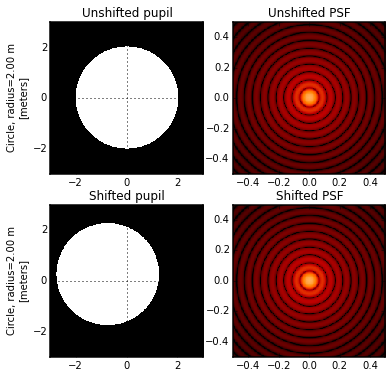

In [55]:
plt.figure(figsize=(6,6))

ap_regular = poppy.CircularAperture(radius=2, pad_factor=1.5)  # pad_factor is important here - without it you will
ap_shifted = poppy.CircularAperture(radius=2, pad_factor=1.5)  # crop off part of the circle outside the array.
ap_shifted.shift_x =-0.75
ap_shifted.shift_y = 0.25

plt.figure(figsize=(6,6))

for optic, title, i in [(ap_regular, 'Unshifted', 1), (ap_shifted, 'Shifted', 3)]:

    sys = poppy.OpticalSystem()
    sys.addPupil(optic)
    sys.addDetector(0.010, fov_pixels=100)
    psf = sys.calcPSF()

    ax1 = plt.subplot(2,2,i)
    optic.display(nrows=2, colorbar=False, ax=ax1)
    ax1.set_title(title+' pupil')
    ax2 = plt.subplot(2,2,i+1)
    poppy.display_PSF(psf,ax=ax2, colorbar=False)
    ax2.set_title(title+' PSF')
    
plt.savefig('example_shift_comparison.png', dpi=100)


In addition to setting the attributes as shown in the above example, these
options can be set directly in the initialization of such elements::



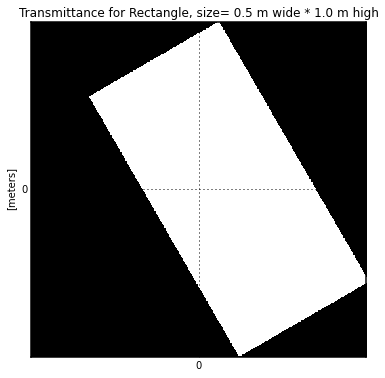

In [58]:
plt.figure(figsize=(6,6))

ap = poppy.RectangleAperture(rotation=30, shift_x=0.1)
ap.display(colorbar=False)
plt.savefig('example_shift_and_rotate.png', dpi=100)